<h1>
<hr style=" border:none; height:3px;">
<center>Custom Logo - Dreamshaper finetuned</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Clément VERON | Edouard SEGUIER</center></h4>

In [1]:
from datasets import load_dataset
from diffusers import UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
import torch
import matplotlib.pyplot as plt
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import mse_loss

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I - Dataset

In [2]:
ds = load_dataset("logo-wizard/modern-logo-dataset")
train_dataset = ds['train']

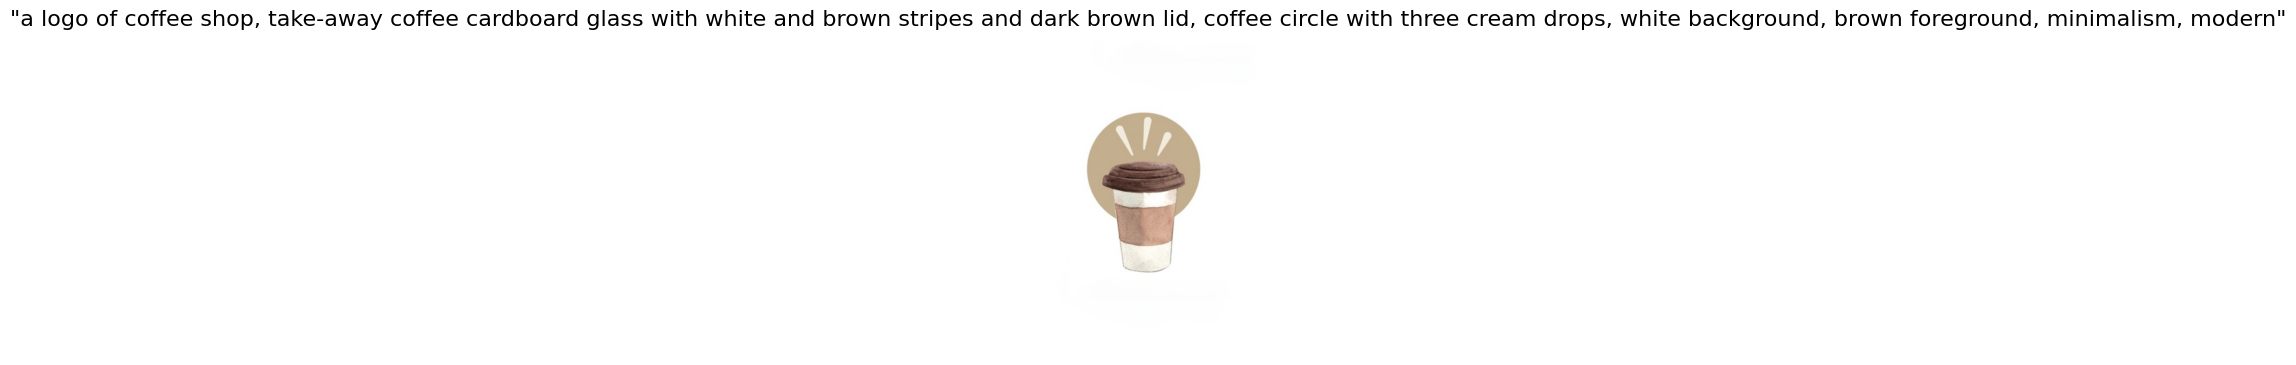

In [3]:
first_item = ds['train'][0]
image = first_item['image']
text = first_item['text']

plt.figure(figsize=(4, 6))
plt.imshow(image)
plt.axis("off")
plt.title(text, fontsize=16)
plt.show()

# II - Base model

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
print("Tokenizer loaded")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
print("Text encoder loaded")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
print("VAE loaded")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
print("Unet loaded")

Tokenizer loaded
Text encoder loaded
VAE loaded
Unet loaded


# III - Config, peft model

In [5]:
target_modules = [
    "mid_block.attentions.0.proj_in",
    "mid_block.attentions.0.proj_out",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_q",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_k",
    "mid_block.attentions.0.transformer_blocks.0.attn1.to_v",
]

config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none"
)

lora_unet = get_peft_model(unet, config)
lora_unet = lora_unet.to("cuda")
optimizer = torch.optim.AdamW(lora_unet.parameters(), lr=1e-4)

# IV - Lora fine tuning

In [6]:
# ==== Transformation pipeline ====
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 or desired size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # Normalize pixel values
])

In [7]:
# from tqdm import tqdm
# # Transform and save dataset as a .pkl file
# processed_data = []
# for item in ds['train']:
#     image = item['image']
#     if image.mode != 'RGB':
#         image = image.convert('RGB')  # Remove alpha channel if present
#     transformed_image = transform(image)
#     processed_data.append({'image': transformed_image, 'text': item['text']})

# with open('processed_dataset.pkl', 'wb') as f:
#     pickle.dump(processed_data, f)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, pkl_file):
        with open(pkl_file, 'rb') as f:
            self.data = pickle.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return item['image'], item['text']

pkl_file = "processed_dataset.pkl"
dataset = CustomDataset(pkl_file)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True) 

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

In [9]:
text_encoder = text_encoder.to("cuda")
criterion = mse_loss
projection_layer = torch.nn.Linear(768, 3 * 256 * 256).to("cuda")  # Map text features to image feature space

In [10]:
for images, texts in dataloader:
    images = images.to("cuda")
    inputs = tokenizer(list(texts), return_tensors="pt", padding=True)
    inputs = {key: tensor.to("cuda") for key, tensor in inputs.items()}
    inputs['position_ids'] = torch.arange(0, inputs['input_ids'].size(1), device="cuda").unsqueeze(0).expand_as(inputs['input_ids'])
    outputs = text_encoder(**inputs)
    pooled_output = outputs.pooler_output

    # Map pooled_output to the image space with the correct number of channels
    projected_output = projection_layer(pooled_output).view(-1, 3, 256, 256)

    # Ensure shapes match
    if projected_output.shape != images.shape:
        raise ValueError(f"Shape mismatch: projected_output {projected_output.shape} vs images {images.shape}")

    # Calculate the loss
    loss = criterion(projected_output, images)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Token indices sequence length is longer than the specified maximum sequence length for this model (88 > 77). Running this sequence through the model will result in indexing errors


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Save the LoRA model
lora_unet.save_pretrained("lhotte_logo_small.safetensors", safe_serialization=True)